<a href="https://colab.research.google.com/github/vlad98rus/-netology_pyda/blob/HomeWork-1/CV_CNN_Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДИПЛОМНАЯ РАБОТА
## Компьютерное зрение. Свертоные нейронные сети.
### Григорьев В.С.

## Импортируем необходимые библиотеки

In [2]:
import zipfile                                                                            # библиотека для работы с zip архивами
import os                                                                                 # Библиотека для работы с файловой ситемой

from google.colab import drive                                                            # модуль для работы с Google Disc

import cv2
import numpy as np                                                                        # linear algebra
import pandas as pd                                                                       # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt                                                           # Ploting charts
import seaborn as sns
import imgaug.augmenters as iaa

from pathlib import Path                                                      
from glob import glob                                                                     # retriving an array of files in directories

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential                                                       # for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator                                  # Data augmentation and preprocessing
from keras.utils import to_categorical                                                    # For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop                                           # For Optimizing the Neural Network
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

%matplotlib inline

print("Tensorflow version: ", tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version:  2.3.0


In [3]:
# подключаем Google Disc / или прописываем свой путь к папке с данными
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Прописываем пут к файлу с архивом
zip_file = '/content/drive/My Drive/PNEUMONIA_dataset.zip'

# распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# просмотр результата разархивации
print (os.listdir())

['.config', 'test', 'drive', 'val', 'train', 'sample_data']


In [5]:
# Path to the data directory
data_dir_test_N = Path('/content/test/NORMAL')
data_dir_test_P = Path('/content/test/PNEUMONIA')

data_dir_train_N = Path('/content/train/NORMAL')
data_dir_train_P = Path('/content/train/PNEUMONIA')

data_dir_val_N = Path('/content/val/NORMAL')
data_dir_val_P = Path('/content/val/PNEUMONIA')

# Get list of all the images
images_test_N = list(data_dir_test_N.glob('*.jpeg'))
images_test_P = list(data_dir_test_P.glob('*.jpeg'))

images_train_N = list(data_dir_train_N.glob('*.jpeg'))
images_train_P = list(data_dir_train_P.glob('*.jpeg'))

images_val_N = list(data_dir_val_N.glob('*.jpeg'))
images_val_P = list(data_dir_val_P.glob('*.jpeg'))

print('Number of images test NORMAL: ', len(images_test_N))
print('Number of images test PNEUMONIA: ', len(images_test_P))

print('Number of images train NORMAL: ', len(images_train_N))
print('Number of images train PNEUMONIA: ', len(images_train_P))

print('Number of images val NORMAL: ', len(images_val_N))
print('Number of images val PNEUMONIA: ', len(images_val_P))

Number of images test NORMAL:  234
Number of images test PNEUMONIA:  390
Number of images train NORMAL:  1341
Number of images train PNEUMONIA:  3875
Number of images val NORMAL:  8
Number of images val PNEUMONIA:  8


## Data Analysis and Preprocessing
## Просмотрим наш датасет

### Тестовая выборка

Shape of images_test_N:  (1509, 2111, 3)
Shape of images_test_N:  (1585, 1785, 3)
Shape of images_test_N:  (1377, 1754, 3)
Shape of images_test_N:  (1412, 2026, 3)


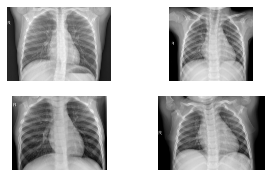

In [6]:
# Let's take a look at some samples first. 
# Always look at your data!
sample_images_test_N = images_test_N[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images_test_N[i]))
    print('Shape of images_test_N: ', img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Shape of images_test_P:  (648, 1184, 3)
Shape of images_test_P:  (1095, 1720, 3)
Shape of images_test_P:  (744, 1336, 3)
Shape of images_test_P:  (817, 1128, 3)


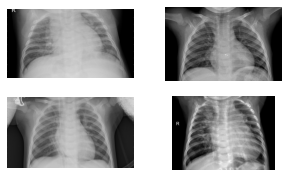

In [7]:
sample_images_test_P = images_test_P[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images_test_P[i]))
    print('Shape of images_test_P: ', img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

### Обучаемая выборка

Shape of images_train_N:  (1194, 1338, 3)
Shape of images_train_N:  (2438, 2721, 3)
Shape of images_train_N:  (1248, 1588, 3)
Shape of images_train_N:  (1433, 1636, 3)


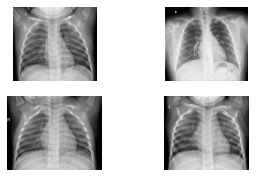

In [8]:
sample_images_train_N = images_train_N[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images_train_N[i]))
    print('Shape of images_train_N: ', img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Shape of images_train_P:  (792, 1264, 3)
Shape of images_train_P:  (592, 1096, 3)
Shape of images_train_P:  (1488, 1768, 3)
Shape of images_train_P:  (680, 976, 3)


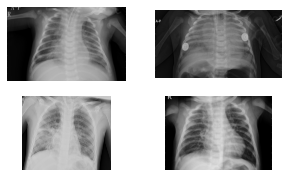

In [9]:
sample_images_train_P = images_train_P[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images_train_P[i]))
    print('Shape of images_train_P: ', img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

### Контрольная (валидационная) выборка

Shape of images_val_N:  (1416, 1776, 3)
Shape of images_val_N:  (1040, 1272, 3)
Shape of images_val_N:  (1225, 1632, 3)
Shape of images_val_N:  (1416, 1736, 3)


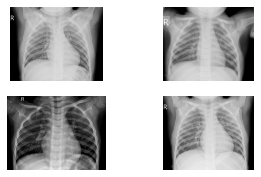

In [10]:
sample_images_val_N = images_val_N[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images_val_N[i]))
    print('Shape of images_val_N: ', img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Shape of images_val_P:  (792, 1264, 3)
Shape of images_val_P:  (592, 1096, 3)
Shape of images_val_P:  (1488, 1768, 3)
Shape of images_val_P:  (680, 976, 3)


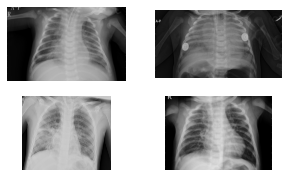

In [11]:
sample_images_val_P = images_train_P[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images_val_P[i]))
    print('Shape of images_val_P: ', img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

## Начинаем работу с тренировочной выборкой

In [12]:
# Создадим список всех изображений
normal_cases = data_dir_train_N.glob('*.jpeg')
pneumonia_cases = data_dir_train_P.glob('*.jpeg')

# Создадим пустой список. Мы вставим данные в этот список в формате (img_path, label)
train_data = []

# Отметим наши изображения в NORMAL_CASES как 0
for img in normal_cases:
    train_data.append((img,0))

# Отметим наши изображения в PNEUMONIA_CASES как 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Создадим из нашего списка датафрейм данных pandas 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Перемешаем наши данные
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Посмотрим что получилось
train_data.head(10)

,image,label
0,/content/train/NORMAL/IM-0363-0001.jpeg,0
1,/content/train/PNEUMONIA/person61_bacteria_294...,1
2,/content/train/PNEUMONIA/person290_bacteria_13...,1
3,/content/train/PNEUMONIA/person589_bacteria_24...,1
4,/content/train/NORMAL/NORMAL2-IM-0515-0001.jpeg,0
5,/content/train/NORMAL/IM-0428-0001.jpeg,0
6,/content/train/NORMAL/IM-0369-0001.jpeg,0
7,/content/train/PNEUMONIA/person581_bacteria_23...,1
8,/content/train/PNEUMONIA/person1258_virus_2138...,1
9,/content/train/NORMAL/NORMAL2-IM-1171-0001.jpeg,0


## Отобразим графически наши тренировочные данные.


1    3875
0    1341
Name: label, dtype: int64


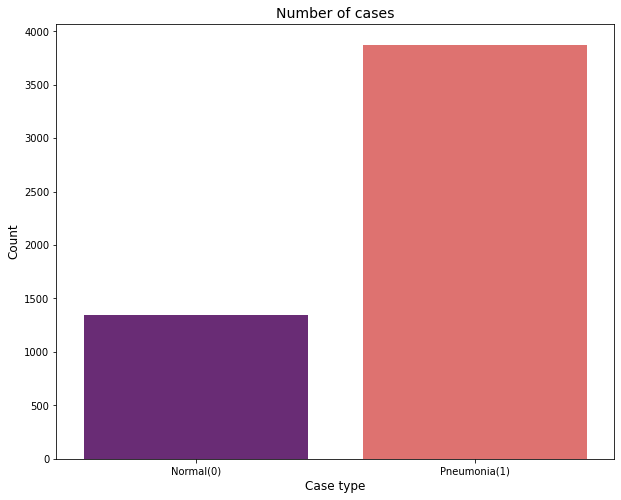

In [13]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x = cases_count.index,  y= cases_count.values, palette="magma")
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

Как вы можете видеть, данные сильно несбалансированы. У нас здесь почти в три раза больше случаев пневмонии по сравнению с обычными случаями. Такая ситуация вполне нормальна, когда речь заходит о медицинских данных. Данные всегда будут несбалансированными. либо будет слишком много нормальных случаев, либо будет слишком много случаев с болезнью.

Давайте посмотрим, чем обычный случай отличается от случая пневмонии. Мы рассмотрим некоторые примеры из самих наших тренировочных данных.

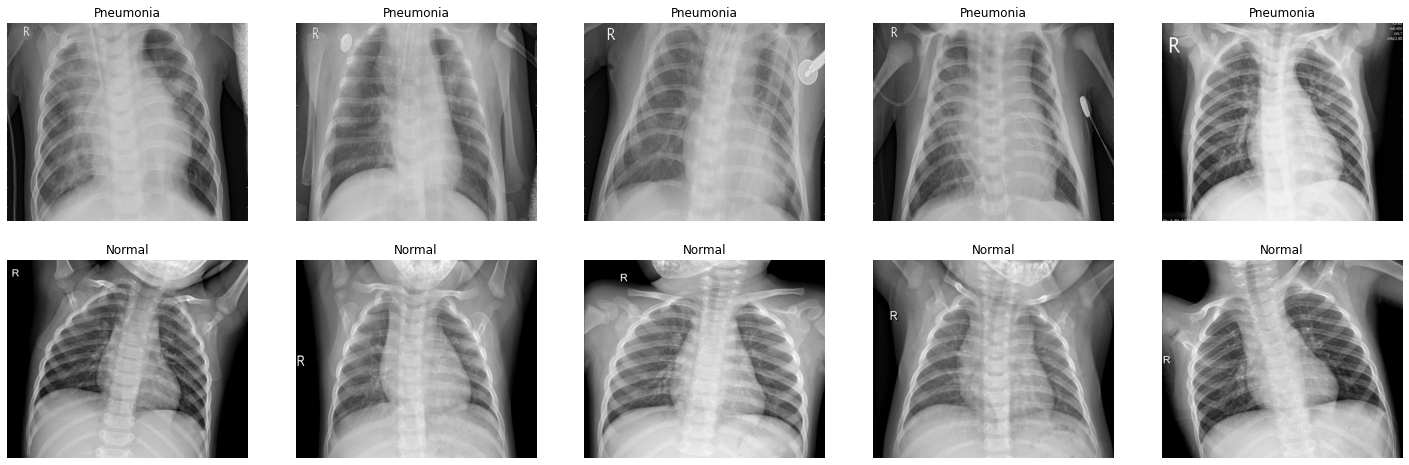

In [14]:
# Создадим несколько образцов для наших классов
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# соеденим наши образцы
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# выводим на печать 
f, ax = plt.subplots(2,5, figsize=(25,8))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Можно рассматривать долго полученные изображения из датасета, и не увидеть, ровным счетом, ничего!

Нам нужно с этим что-то делать.


## Задаем необходимые параметры для дальнейшего обучения.


In [15]:
classes = ["NORMAL", "PNEUMONIA"]
data_gen = ImageDataGenerator() # Генерация пакетов данных тензорного изображения с дополнением данных в реальном времени

In [16]:
path_test = Path('/content/test')
path_train = Path('/content/train')
path_val = Path('/content/val')
 
test_batches = data_gen.flow_from_directory(path_test, target_size = (224, 224), classes = classes, class_mode = "categorical")
train_batches = data_gen.flow_from_directory(path_train, target_size = (224, 224), classes = classes, class_mode = "categorical")
val_batches = data_gen.flow_from_directory(path_val, target_size = (224, 224), classes = classes, class_mode = "categorical")


Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [17]:
print(test_batches.image_shape)
print(train_batches.image_shape)
print(val_batches.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [20]:
# VGG16 Model - сверточная нейронная сеть для выделения признаков изображений 

model = Sequential() # Настраивает модель Keras Sequential для обучения.


# добавим необходимые слои с помощью метода .add():


model.add(ZeroPadding2D((1,1),input_shape=train_batches.image_shape)) # Слой нулевого пэддинга для 2D-входа (например, изображение).
model.add(Conv2D(64, (3, 3), activation='relu')) # пространственная свертка Conv2D для изображения
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu')) # kernel size 3x3  
model.add(MaxPooling2D((2,2), strides=(2,2))) # Операция максимальной подвыборки (субдискретизации) для пространственных данных..

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu')) # Добавляем Dense-слой на 4096 нейронов
model.add(Dropout(0.5))  # используем Dropout для предотвращения переобучения
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


In [21]:
# Посмотрим на полученные данные нашей модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

## Тренировка и настройка CNN

In [ ]:
optimizer = Adam(learning_rate = 0.0001)

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer) 

history = model.fit(
                    train_batches,
                    epochs=5,  
                    shuffle=True, 
                    validation_data=val_batches,  
                    steps_per_epoch=100, 
                    validation_steps=2
                    )
prediction = model.predict(
                            train_batches,
                            verbose=2, 
                            steps=100
                           )

## Выводим результат

In [ ]:
# для параметра ACCUARCY

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# для параметра LOSS

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()